In [2]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import boto3
import sagemaker
import tarfile
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sagemaker.serializers import CSVSerializer
from sagemaker.model import Model
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from time import gmtime, strftime
from scipy.stats import ks_2samp
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, RegressionPreset

sagemaker.config INFO - Not applying SDK defaults from location: /opt/homebrew/share/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/darian/Library/Application Support/sagemaker/config.yaml


         age   bmi  children     region  expenses  sex_male  smoker_yes
0         22  25.6         0  southeast   7640.29      True       False
1         54  20.4         2  northeast  12887.22      True       False
2         61  47.3         0  northwest  36393.72     False        True
3         29  37.5         2  southeast   3513.63     False       False
4         24  26.5         2  southeast   1163.46     False       False
...      ...   ...       ...        ...       ...       ...         ...
4999995   40  38.6         0  northwest  17685.33     False       False
4999996   30  39.8         0  northeast   3354.64      True       False
4999997   30  20.3         2  northeast   1146.80     False       False
4999998   29  26.2         0  southeast   2476.62     False       False
4999999   34  29.7         5  northeast   1924.05     False       False

[5000000 rows x 7 columns]


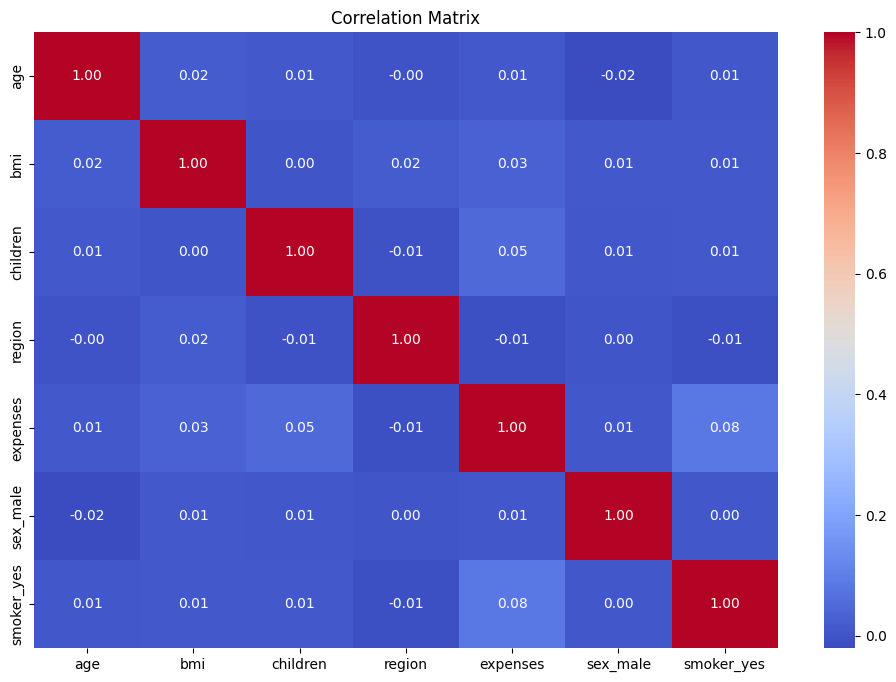

                age           bmi      children        region      expenses  \
count  5.000000e+06  5.000000e+06  5.000000e+06  5.000000e+06  5.000000e+06   
mean   3.956089e+01  3.099166e+01  1.368067e+00  1.538714e+00  1.168016e+04   
std    1.467582e+01  7.188340e+00  1.399821e+00  1.102212e+00  1.184611e+04   
min    1.800000e+01  1.730000e+01  0.000000e+00  0.000000e+00  1.137470e+03   
25%    2.700000e+01  2.520000e+01  0.000000e+00  1.000000e+00  3.733407e+03   
50%    3.900000e+01  3.080000e+01  1.000000e+00  2.000000e+00  8.107220e+03   
75%    5.200000e+01  3.620000e+01  2.000000e+00  3.000000e+00  1.403393e+04   
max    6.400000e+01  4.770000e+01  5.000000e+00  3.000000e+00  5.259083e+04   

           sex_male    smoker_yes  
count  5.000000e+06  5.000000e+06  
mean   3.933838e-01  1.344610e-01  
std    4.885008e-01  3.411470e-01  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  
75%    1.000000e+00  0.000000e+00  


In [3]:

# Load data
data = pd.read_csv('../data/large_inference.csv')

# Identify categorical features
categorical_features = ['sex', 'region', 'smoker']

# One-Hot Encoding for binary categorical features
data = pd.get_dummies(data, columns=['sex', 'smoker'], drop_first=True)
print(data)
# Convert bool to int64
data['sex_male'] = data['sex_male'].astype('int64')
data['smoker_yes'] = data['smoker_yes'].astype('int64')

# Label Encoding for ordinal relationship
label_encoder = LabelEncoder()
data['region'] = label_encoder.fit_transform(data['region'])

# Visualize correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print(data.describe())

encoded_large = pd.DataFrame(data)



In [5]:
useful_data = data[1000:]

# Split the data into features and target
X = useful_data.drop(columns=['expenses'])
y = useful_data['expenses']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(
    n_estimators=600,
    min_samples_split=10,
    min_samples_leaf=4
)
model.fit(X_train, y_train)

# Predictions and evaluation
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
evs = explained_variance_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'Explained Variance Score: {evs}')

# Cross-validation performance metrics
cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
cv_evs = cross_val_score(model, X_train, y_train, cv=5, scoring='explained_variance')

print('Cross-Validation Performance metrics')
print(f'CV RMSE: {cv_rmse.mean()}')
print(f'CV R^2: {cv_r2.mean()}')
print(f'CV Explained Variance Score: {cv_evs.mean()}')

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred, label='Predicted vs Actual')
m, b = np.polyfit(y_test, pred, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Line of Best Fit')

plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')
plt.title(f'{model.__class__.__name__}: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

print("Model successfully trained")

KeyboardInterrupt: 